# Deep Learning Demand Forecasting
*Made by Carmen Pelayo Fernández in March, 2024*

This project addresses the critical need for effective demand forecasting in local businesses, utilizing deep learning methods. By analyzing over two decades of data from a Connecticut café, we aim to explore and identify deep learning algorithms that provide highly accurate demand projections, aiding in operational planning and strategic decision-making.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
data = pd.read_excel("VBCData.xlsx")
data.head()

,Unnamed: 0,Unnamed: 1,Date,Day,Breakfast,Lunch,Dinner,Total,Weather,Notes,Unnamed: 10,Avg Spend
0,NaN,NaN,2023-12-31,Sunday,88,105,0,193,Overcast,NaN,3649.27,18.908135
1,NaN,NaN,2023-12-30,Saturday,56,149,28,233,PM Rain,NaN,4643.05,19.927253
2,NaN,NaN,2023-12-29,Friday,30,154,17,201,PM Rain,NaN,3715.30,18.484080
3,NaN,NaN,2023-12-28,Thursday,26,154,21,201,PM Rain,NaN,3677.01,18.293582
4,NaN,NaN,2023-12-27,Wednesday,43,138,13,194,PM Rain,NaN,3239.03,16.696031


The following actions were taken to preprocess the data before we begin the analysis:
* Dropped unnecessary columns.
* Named column 'Revenue'.
* Checked data types.

In [21]:
data = data.drop(columns=["Unnamed: 0", "Unnamed: 1"]).rename(columns={"Unnamed: 10": "Revenue"})
data.dtypes

Date          datetime64[ns]
Day                   object
Breakfast              int64
Lunch                  int64
Dinner                 int64
Total                  int64
Weather               object
Notes                 object
Revenue              float64
Avg Spend            float64
dtype: object

All columns seem to have the proper data type. Therefore, no formatting is required here. The preprocessed dataset to be used will be the following:

In [4]:
data

,Date,Day,Breakfast,Lunch,Dinner,Total,Weather,Notes,Revenue,Avg Spend
0,2023-12-31,Sunday,88,105,0,193,Overcast,NaN,3649.27,18.908135
1,2023-12-30,Saturday,56,149,28,233,PM Rain,NaN,4643.05,19.927253
2,2023-12-29,Friday,30,154,17,201,PM Rain,NaN,3715.30,18.484080
3,2023-12-28,Thursday,26,154,21,201,PM Rain,NaN,3677.01,18.293582
4,2023-12-27,Wednesday,43,138,13,194,PM Rain,NaN,3239.03,16.696031
...,...,...,...,...,...,...,...,...,...,...
9074,2000-01-05,Wednesday,8,110,20,138,NaN,NaN,1320.27,9.567174
9075,2000-01-04,Tuesday,5,92,0,97,NaN,NaN,1077.91,11.112474
9076,2000-01-03,Monday,3,79,0,82,Part Sunny,Warm,840.04,10.244390
9077,2000-01-02,Sunday,55,161,29,245,NaN,NaN,2259.14,9.220980


## Exploratory Data Analysis (EDA)

I will begin the project with a Exploratory Data Analysis performing some simple **statistics** and **visualizations** to observe the nature of the data and gain insights about it.

### Data Summary

In [5]:
data.describe()

,Date,Breakfast,Lunch,Dinner,Total,Revenue,Avg Spend
count,9079,9079.000000,9079.000000,9079.000000,9079.000000,9070.000000,8915.000000
mean,2012-05-15 19:43:12.840621312,31.088115,133.909131,37.508316,202.517678,2985.114173,14.730858
min,2000-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006-03-19 12:00:00,8.000000,87.000000,0.000000,114.000000,1561.997500,12.609058
50%,2012-06-05 00:00:00,15.000000,119.000000,32.000000,172.000000,2508.100000,14.318143
75%,2018-08-22 12:00:00,40.000000,162.000000,59.000000,260.500000,3929.772500,16.126611
max,2023-12-31 00:00:00,222.000000,585.000000,209.000000,821.000000,14833.490000,568.090000
std,NaN,36.934156,72.448446,37.483778,123.561512,1961.484184,6.894470


From this summary table we can observe there are **missing values.** The dataset contains records from 9,079 days (i.e. 9078/366 = 24.8 years). Interestingly, we only have 'Avg Spend' (average expenditure) data from 8915 days. That means 164 values are missing and should be handled appropriately. Similarly, we only have 'Revenue' data from 9070 days, meaning 9 values are missing. Missing values should either be dropped or filled in with interpolated data to prevent the impact of null values on predictions. Given the time series nature of the problem, dropping values would discontinue the series and this could cause problems. Therefore, we will fill in the missing values. There are multiple methods to do so, including the *mean imputation*, *median imputation*, *Last Observation Carried Forward (LOCF)*, *Next Observation Carried Backward (NOCB)*, *linear interpolation* or the *spline imputation* ([GeeksForGeeks](https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/), accessed March 2024). Given that there are only a small number of missing values, we can perform **spline interpolation** on them, which is the most comùtationally expensive method but also the most accurate for capturing complex trends and subtle changes in time series data. It estimates missing values by fitting a flexible, curved line through the data points.

In [22]:
data["Revenue"] = data["Revenue"].interpolate(option='spline')
data["Avg Spend"] = data["Avg Spend"].interpolate(option='spline')

### Revenue Evolution

The **total revenue per quarter** will now be plotted to observe how revenue has evolved over the years.

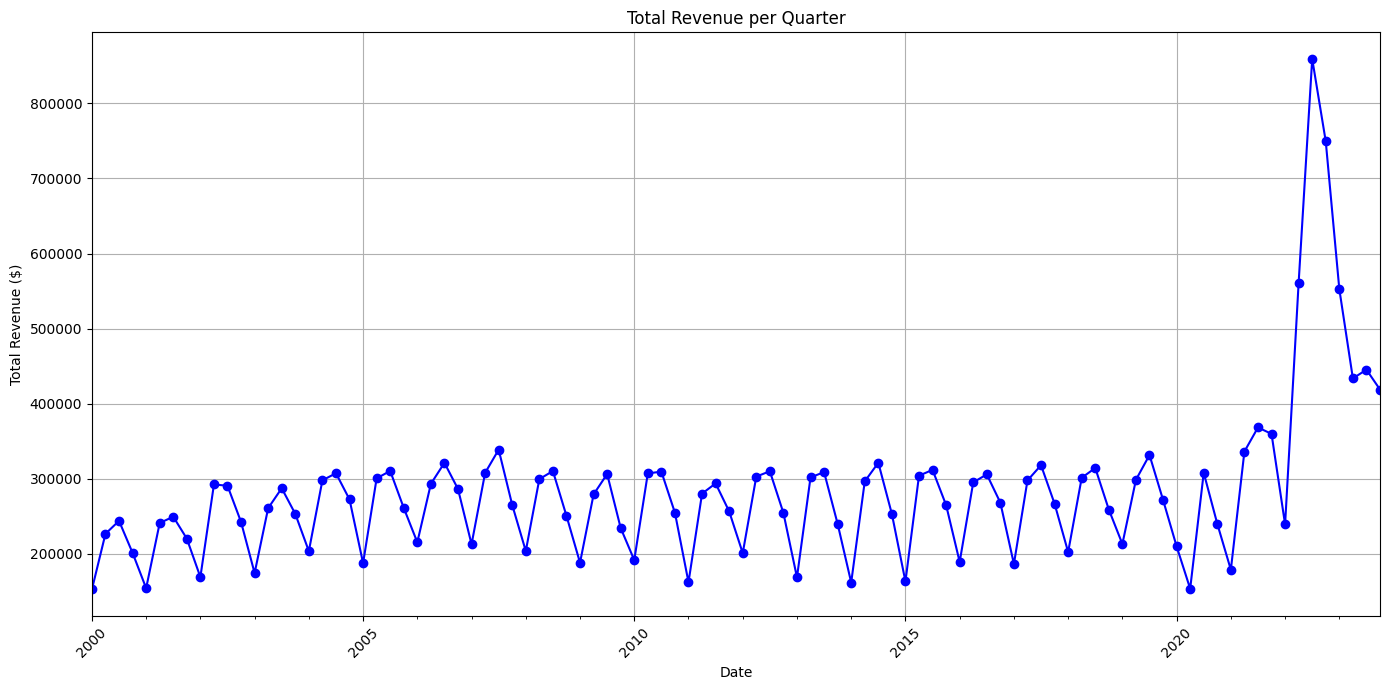

In [23]:
# Data Resampling (to obtain quarterly observations)
data.set_index('Date', inplace=True)
quarterly_data = data['Revenue'].resample('QE').sum()

# Plotting
plt.figure(figsize=(14, 7))
quarterly_data.plot(marker='o', linestyle='-', color='b')
plt.title('Total Revenue per Quarter')
plt.xlabel('Date')
plt.ylabel('Total Revenue ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

The data seems to have a clear **seasonality**, with a constant trend over the years and low variance (at least until 2021). This pattern is very convenient for time series modeling, enabling accurate predictions due to the apparent lack of random shocks that could reduce the predictability of models. Throughout the entire series, we can see that the **first quarter** of the year (i.e. the months of January, February, March) produces the **lowest earnings** in the year, with the second (April, May, June) and third (July, August, September) quarters (the **warmer months**) being the **most profitable** ones. 

### Outliers and Data Duplicates

However, this smooth seasonality is broken with the presence of a clear **outlier during 2022**. This year, revenue almost reached 3 times the value of other years' revenue. This could be due to either the effect of external factors or issues in the data collection process. During part II of this project (*Long-Term Trend Forecasting*) we will focus on the investigation of economic and sociodemographic events that may have altered the usual course of the data. However, it is interesting to note that the effect of COVID-19 (as a reference for a major sociodemographic event that impacted most businesses in the world), does not show an extreme decay in revenue. This may be indicative of 2022's outlier being potentially due to issues in the data collection process. To check for this, we will first check for **duplicated records** in the data:

In [24]:
duplicate_dates = data[data.index.duplicated()]
duplicate_dates

,Day,Breakfast,Lunch,Dinner,Total,Weather,Notes,Revenue,Avg Spend
Date,,,,,,,,,
2023-04-25,Tuesday,21,84,0,105,Cold As F,NaN,2127.22,20.259238
2023-03-31,Friday,25,112,59,196,NaN,NaN,3760.30,19.185204
2023-03-30,Thursday,36,99,25,160,NaN,NaN,3238.70,20.241875
2023-03-29,Wednesday,8,107,25,140,NaN,NaN,2470.46,17.646143
2023-03-28,Tuesday,12,87,0,99,NaN,NaN,1858.06,18.768283
...,...,...,...,...,...,...,...,...,...
2022-05-27,Friday,21,133,95,249,NaN,NaN,4586.17,18.418353
2022-05-26,Thursday,24,154,40,218,NaN,NaN,4139.37,18.987936
2022-05-25,Wednesday,17,140,52,209,Beautiful,NaN,3877.41,18.552201


As suspected, there are **314 duplicated values** in the dataset. We will then proceed to remove them and replot the to quarterly revenues:

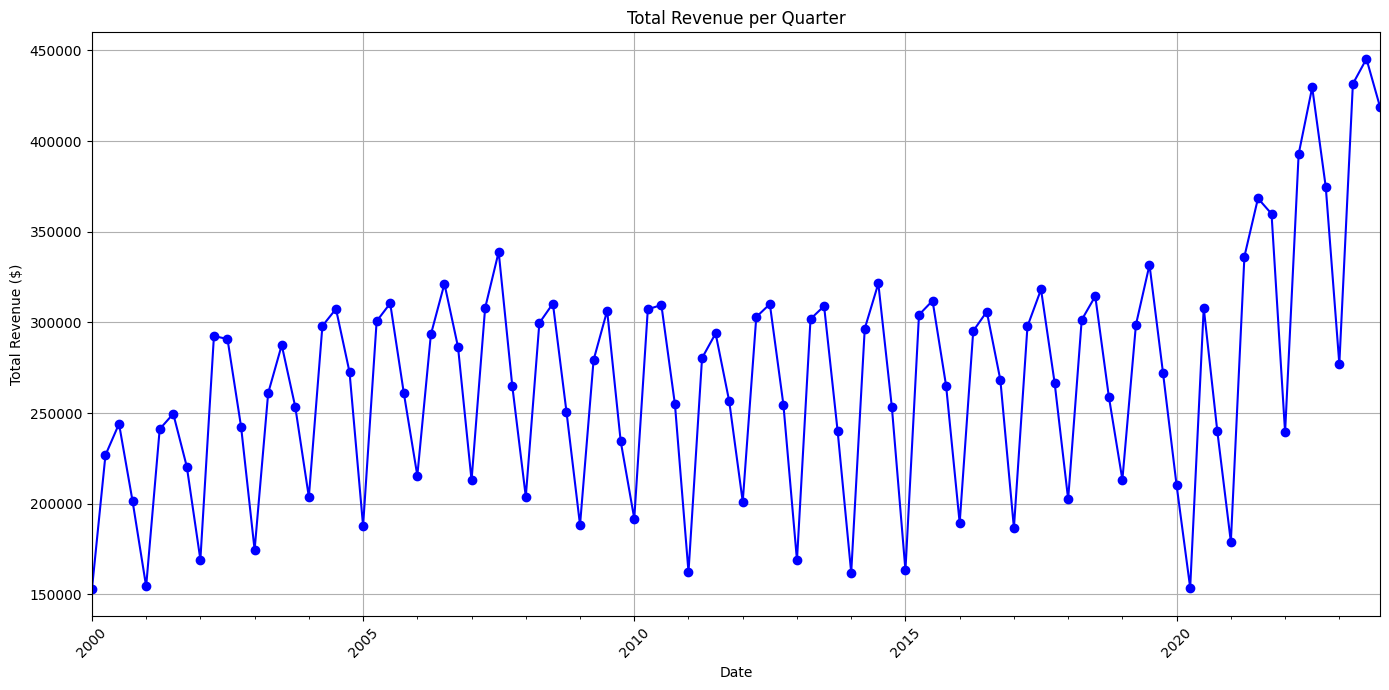

In [25]:
data = (data.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index())
quarterly_revenue = data['Revenue'].resample('QE').sum()

plt.figure(figsize=(14, 7))
quarterly_revenue.plot(marker='o', linestyle='-', color='b')
plt.title('Total Revenue per Quarter')
plt.xlabel('Date')
plt.ylabel('Total Revenue ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

This seems much more reasonable. Still, there is some interesting **increase after the COVID-19 pandemic** that we will explore later. With a clean dataset now, we can go on to plot more visualizations.

### Meals Evolution

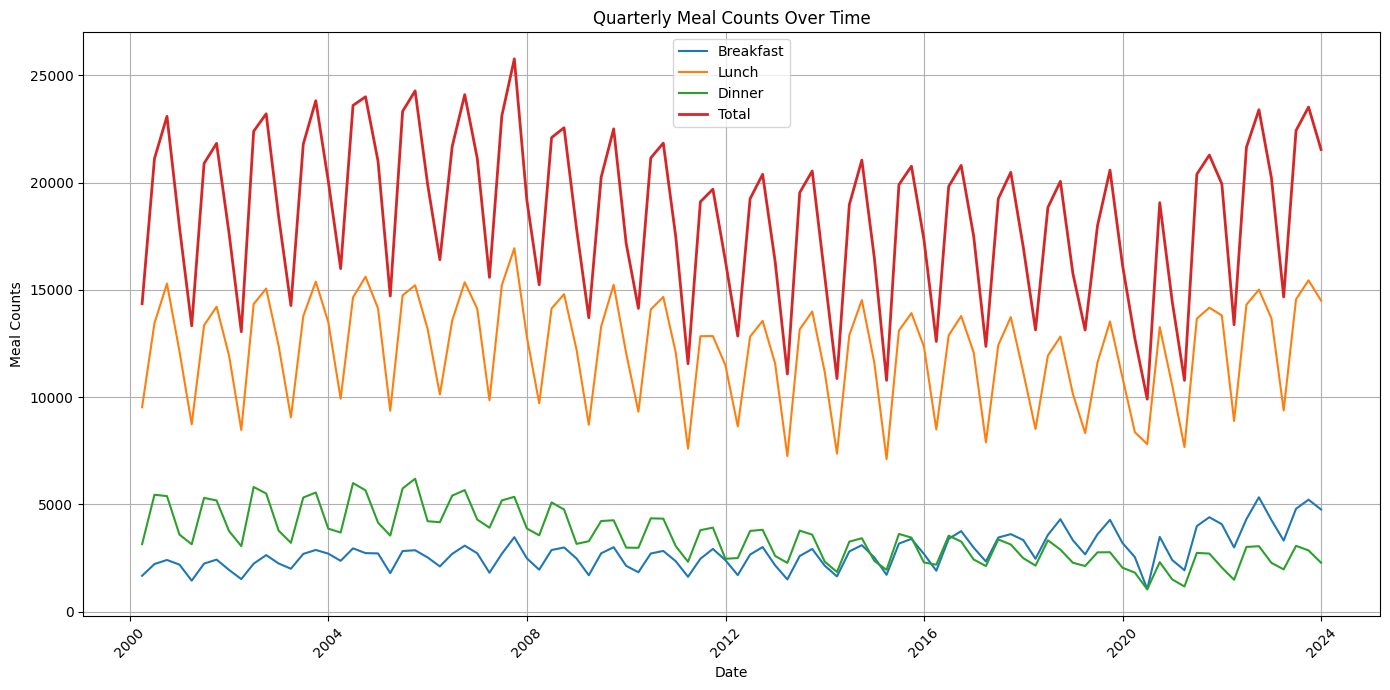

In [10]:
# Data Resampling (to obtain quarterly observations)
quarterly_meals = data[['Breakfast ', 'Lunch', 'Dinner', 'Total']].resample('QE').sum()

plt.figure(figsize=(14, 7))

# Plot each column as a line on the same graph
plt.plot(quarterly_meals.index, quarterly_meals['Breakfast '], label='Breakfast')
plt.plot(quarterly_meals.index, quarterly_meals['Lunch'], label='Lunch')
plt.plot(quarterly_meals.index, quarterly_meals['Dinner'], label='Dinner')
plt.plot(quarterly_meals.index, quarterly_meals['Total'], label='Total', linewidth=2)  # Highlighting the 'Total' line

plt.title('Quarterly Meal Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Meal Counts')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

This graph displays the counts of meals served over time, broken down by meal type: breakfast, lunch, dinner, and the total count of meals. It confirms the seasonality observed earlier, as the general levels of meal counts seem relatively consistent over the years despite some fluctuations. This suggests a **steady business performance** without significant long-term changes in customer behavior. The plot also shows **lunch being the most popular choice for customers**, followed by dinner. However, **around 2014, breakfast became more popular**, eventually and permanently surpassing dinners in the years after.

### Correlations

A **correlation heatmap** will now be plotted to observe how variables relate to one another and potentially disclosing interesting relationships.

<Axes: >

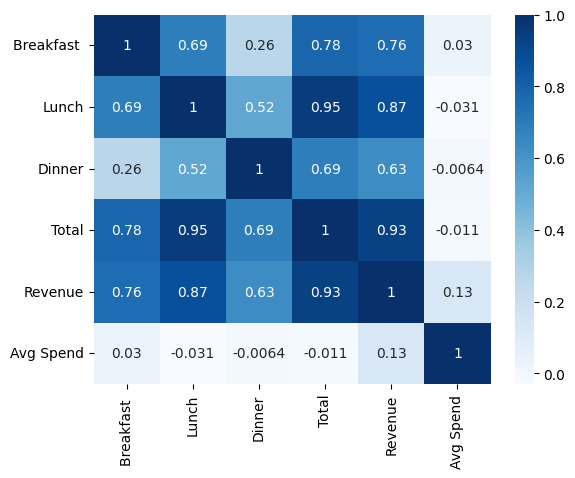

In [11]:
numdata = data.select_dtypes(include=np.number)
corr = numdata.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

This correlation heatmap confirms our previous observations, with **lunch having the highest correlation with revenue** (0.87), implying it is probably the main source of revenue for the business. On the other hand, Average spending (Avg Spend) shows very little to no correlation with meal counts or revenue, suggesting that the **average spending per customer is independent of the volume of meals sold**. This is useful to discard the hypothesis that busier days in the restaurant (for instance, due to a special sports event) or celebration reservations (i.e. people booking space for their guests) do not imply people will spend more.

## Basic Time Series Forecasting

After performing an EDA, we can now proceed to perform some basic forecasting in our (now well processed) time series dataset. We will focus on predicting the **short-term demand of daily meals**. As such, variable `Total` will be the target value in the models to be built here.

### Auto-Regressive Integrated Moving Average (ARIMA)

In [12]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

I will use the `auto_arima` function from the `pmdarima` package to **automatically estimate the proper order** of the ARIMA model we will fit afterwards.

In [14]:
arima_order = auto_arima(data['Total'], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=105106.796, Time=3.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=110387.191, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=110323.903, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=108276.343, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110385.191, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=106453.393, Time=1.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=105956.481, Time=1.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=105951.520, Time=3.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=103404.877, Time=5.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=105840.143, Time=1.98 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=105088.996, Time=4.53 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=102779.712, Time=5.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=105505.036, Time=3.28 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=6.58 sec
 ARIMA(2,1,5

This returned the best ARIMA model to be that of **order (2,1,5)**. We will therefore fit it with the `ARIMA` function from `statsmodels`.

In [15]:
# Fit the ARIMA(2,0,0) model
data = data.asfreq('D')
model = ARIMA(data['Total'], order=(2, 1, 5), dates=data.index)
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 8766
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -51371.141
Date:                Sun, 31 Mar 2024   AIC                         102758.282
Time:                        23:38:25   BIC                         102814.910
Sample:                    01-01-2000   HQIC                        102777.577
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2458      0.001   1631.531      0.000       1.244       1.247
ar.L2         -0.9995      0.001  -1407.744      0.000      -1.001      -0.998
ma.L1         -1.9787      0.013   -152.871      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The ARIMA(2, 1, 5) model output indicates that all AR and MA coefficients are statistically significant, suggesting a good fit to the data. The model's log likelihood is high, and the AIC, BIC, and HQIC values is low but could be lowered. The Ljung-Box test shows a significant p-value (0.00), indicating potential autocorrelation in residuals. The Jarque-Bera test result is significant, which, along with a kurtosis of 4.52, suggests that the residuals might not be normally distributed. Overall, the model fits well, but the residuals' behavior might need further investigation.

### Long Short-Term Memory (LSTM)

I will now proceed to apply the first deep learning algorithm, LSTMs. **Long Short-Term Memory networks**, or LSTMs, are a special kind of recurrent neural network (RNN) capable of learning long-term dependencies. They are particularly useful for sequence prediction problems due to their ability to retain information over extended time intervals through their internal gating mechanism, which regulates the flow of information. In the context of this project, it is suitable to predict short-term demand in a restaurant by learning from historical sales data, considering patterns such as seasonality, trends, and other cyclic behaviors over time

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [31]:
df = data['Total'].values.astype(float).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(df)
data_normalized = torch.FloatTensor(data_normalized).view(-1)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Reshaping the input data to [samples, time steps, features]
X = X.reshape(X.shape[0], seq_length, -1)  # Adding the features dimension

# Creainge training and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

model = LSTM(input_size=1, hidden_layer_size=100, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

# Preparing DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)

# Training loop
model.train()
for epoch in range(75):  # Adjust the number of epochs as needed
    for seq, labels in train_loader:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels.view(-1, 1))
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

# Testing loop
model.eval()
with torch.no_grad():
    preds = model(X_test)
    loss = loss_function(preds, y_test.view(-1, 1))
    print(f'Test loss: {loss.item()}')

epoch: 0 loss: 0.07901862263679504
epoch: 10 loss: 0.07189060002565384
epoch: 20 loss: 0.08834513276815414
epoch: 30 loss: 0.0689518079161644
epoch: 40 loss: 0.03562111780047417
epoch: 50 loss: 0.09622970223426819
epoch: 60 loss: 0.09824350476264954
epoch: 70 loss: 0.05554324388504028
Test loss: 0.057270199060440063
